# Parameter scan runs for 1D kinematic driver model

Author: Jatan Buch (v1, 240501) || (v2, 241022)

In [1]:
from case_files.settings_time import Settings 
from case_files.simulation_sd_update import Simulation
import numpy as np
import xarray
from tqdm import tqdm

import itertools
import pandas as pd

from PySDM import Formulae
from PySDM.initialisation.spectra import Lognormal
from PySDM.physics import si
from PySDM.exporters import NetCDFExporter_1d

import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.patches import Rectangle
import matplotlib.patches as patches
import matplotlib.path as mpltPath
from utils.plot_params_mpl39 import params
import matplotlib.pylab as pylab
import seaborn as sns
pylab.rcParams.update(params)
cols_default = plt.rcParams['axes.prop_cycle'].by_key()['color']

%matplotlib inline
%config IPython.matplotlib.backend = 'retina'
%config InlineBackend.figure_format = 'retina'

sav_file_path= "/Users/hyfives-lamont/Desktop/cloud_seeding/sav_files/parameter_scan_1D/"
sav_plt_path= "/Users/hyfives-lamont/Desktop/cloud_seeding/plots/parameter_scan_1D/"

## Case setup

In [2]:
def KiD_run(param, bkg_size= 1E-1, seed_size= 1, z_part_seed= (0., 0.25), rho_times_w= 2, rindx= 0, n_runs= 10, rseed= 42):

        norm_bkg, norm_seed = param

        kappa_bkg= 0.3
        kappa_seed= 0.85
        
        common_params = {
        "t_max": 60 * si.minutes,
        "n_sd_per_mode": (32, 32), 
        "aerosol_modes_by_kappa": {
                kappa_bkg: Lognormal(
                                norm_factor= norm_bkg / si.cm ** 3,
                                m_mode= bkg_size * si.um,
                                s_geom=1.4
                        ),
                kappa_seed: Lognormal(
                                norm_factor= norm_seed / si.cm ** 3,
                                m_mode= seed_size * si.um,
                                s_geom= 1.2
                        )
                },
        "dt": 5 * si.s,
        "dz": 50 * si.m,
        "p0": 990 * si.hPa,
        "z_part": ((0., 1.), z_part_seed),
        "r_seed": 1 * si.um,
        "kappa_seed": 0.85,
        "int_inj_rate": 10 / si.cm ** 3,
        "seed_z_step": [],
        "seed_t_step": [],
        }

        output = {}
        settings = {}
        simulation = {}
        rain_xarr = {}

        np.random.seed(rseed)

        for r_id in range(n_runs):
                key = f"param_list_{rindx}_run={r_id}"
                settings[key] = Settings(
                        **common_params,
                        formulae= Formulae(seed= np.random.randint(1000)),
                        rho_times_w_1=rho_times_w * si.kg/si.m**3 * si.m/si.s,
                        precip= True
                        )
                simulation[key] = Simulation(settings[key])
                output[key] = simulation[key].run().products
                
                rain_xarr[key]= xarray.DataArray(data= output[key]['rain water mixing ratio'],
                                dims=["z", "t"],
                                coords=dict(
                                        t=(["t"], output[key]['t'],),
                                        z=(["z"], output[key]['z'],),)
                                )

        surface_rain= xarray.concat([rain_xarr[f"param_list_{rindx}" + "_run=" + str(i)] for i in range(n_runs)], dim="run")
        surface_rain= surface_rain.assign_coords(run=range(n_runs))

        return surface_rain

In [6]:
norm_bkg= np.logspace(1, np.log10(500), 2)
norm_seed= np.logspace(0, np.log10(500), 2)
#z_part_seed= ((0., 0.25), (0.25, 0.50), (0.5, 0.75) , (0.75, 1.))

param_list= list(itertools.product(norm_bkg, norm_seed))
kid_run_df= pd.DataFrame(param_list, columns= ['norm_bkg', 'norm_seed'])

In [7]:
bkg_size= 1E-1 # in si.um
seed_size= 1 # in si.um
z_part_seed= (0., 0.25)
rho_times_w= 2 # in si.kg/si.m**3 * si.m/si.s

mean_surf_prec_arr= []
sig_surf_prec_arr= []

for i in tqdm(range(len(param_list))): 
    try:
        surface_rain= KiD_run(param= param_list[i], bkg_size= bkg_size, seed_size= seed_size, z_part_seed= z_part_seed, rho_times_w= rho_times_w, rindx=i, n_runs= 20, rseed= 24)
        surface_rain.to_netcdf(sav_file_path + f'KiD_run_{i+1}.nc') # saving the netcdf file
        
        mean_surf_prec_arr.append(surface_rain.sel(z= 25).sum(dim= 't').mean(dim= 'run').values.item())
        sig_surf_prec_arr.append(surface_rain.sel(z= 25).sum(dim= 't').std(dim= 'run').values)
    except:
        mean_surf_prec_arr.append(np.nan)
        sig_surf_prec_arr.append(np.nan)

# add columns to kid_run_df for bkg_size, seed_size, z_part_seed, rho_times_w which are the same for all runs
kid_run_df['bkg_size']= bkg_size 
kid_run_df['seed_size']= seed_size 
kid_run_df['z_part_seed']= [(0., 0.25)] * len(param_list)
kid_run_df['rho_times_w']= 2 

kid_run_df['surf_precip_mean']= np.array(mean_surf_prec_arr)
kid_run_df['surf_precip_std']= np.array(sig_surf_prec_arr)
kid_run_df.to_hdf(sav_file_path + 'KiD_run_summary.h5', key='df')

  0%|          | 0/1 [00:00<?, ?it/s]/Users/hyfives-lamont/Desktop/cloud_seeding/PySDM/PySDM/backends/numba.py:46: UserWarning: Disabling Numba threading due to ARM64 CPU (atomics do not work yet)
  warnings.warn(
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
/Users/hyfives-lamont/Desktop/cloud_seeding/PySDM/PySDM/backends/numba.py:46: UserWarning: Disabling Numba threading due to ARM64 CPU (atomics do not work yet)
  warnings.warn(
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
/Users/hyfives-lamont/Desktop/cloud_seeding/PySDM/PySDM/backends/numba.py:46: UserWarning: Disabling Numba threading due to ARM64 CPU (atomics do not work yet)
  warnings.warn(
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
/Users/hyfives-lamont/Desktop/cloud_seeding/PySDM/PySDM/backends/numba.py:46: UserWarning: Disabling Numba threading due to ARM64 CPU (atomics do not work yet)
  warnings.war

In [8]:
kid_run_df

,norm_bkg,norm_seed,bkg_size,seed_size,z_part_seed,rho_times_w,surf_precip_mean,surf_precip_std
0,500,500,0.1,1,"(0.0, 0.25)",2,80.618889,6.763869


In [5]:
kid_run_df

,norm_bkg,norm_seed,bkg_size,seed_size,z_part_seed,rho_times_w,surf_precip_mean,surf_precip_std
0,50,50,0.1,1,"(0.0, 0.25)",2,81.841008,4.644914
1,50,100,0.1,1,"(0.0, 0.25)",2,84.117031,5.035425
2,500,50,0.1,1,"(0.0, 0.25)",2,71.940444,5.929346
3,500,100,0.1,1,"(0.0, 0.25)",2,75.910527,6.392123


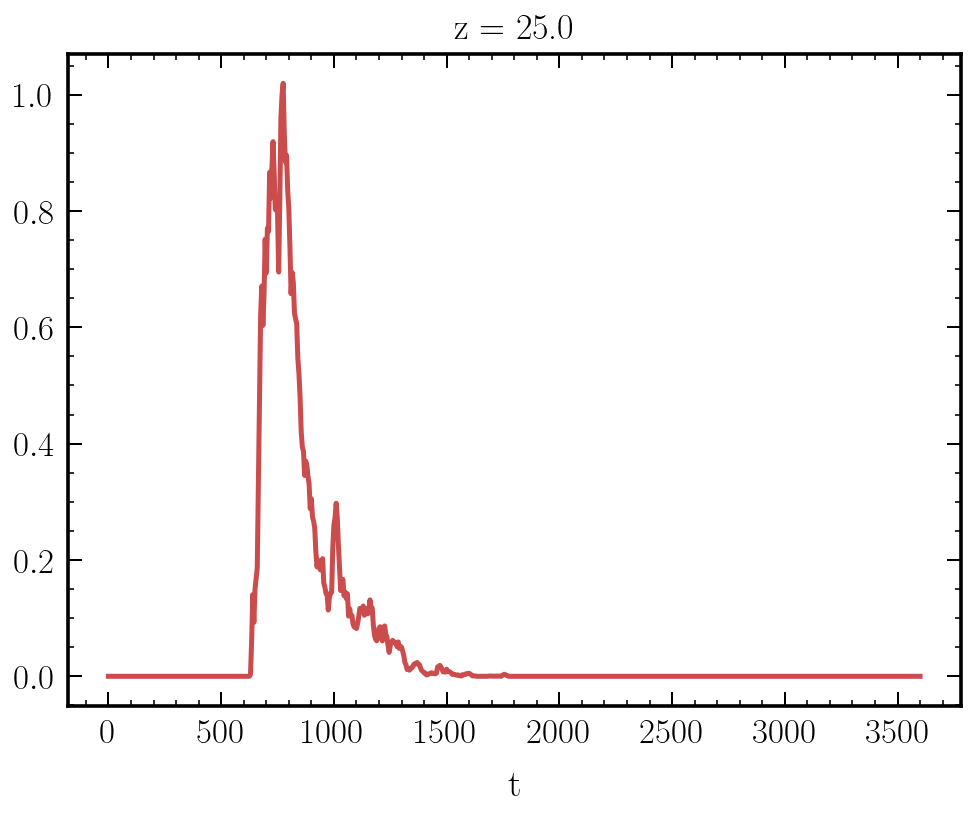

In [24]:
fig, ax= plt.subplots(1, 1, figsize=(8, 6))
surface_rain.mean(dim= "run").sel(z= 25).plot(ax= ax)

In [15]:
(960 * 120)/3600

32.0